## Importing required Libraries

In [1]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB4, EfficientNetB7
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
import os.path
from os import path
import cv2
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tqdm import tqdm
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_validate
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from pathlib import Path
import shutil
import yaml
from tensorflow.keras.activations import swish
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
from keras import backend as K
from io import BytesIO
from PIL import Image

random.seed(34)
# tf.compat.v1.disable_eager_execution()

## Set these variables according to the requirement

In [52]:
# Load the YAML file
working_dir = r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM/"
with open(working_dir + '/Parameters - train with 1 interval.yaml', 'r') as f:
    hyperparameters = yaml.safe_load(f)

# Use the hyperparameters in your neural network model
batch_size = hyperparameters['batch_size']
num_epochs = hyperparameters['num_epochs']
dropout_rate = hyperparameters['dropout_rate']
EPOCHS = hyperparameters['EPOCHS']
interval = hyperparameters['interval']
generate_data = hyperparameters['generate_data']
training_required = hyperparameters['training_required']
working_dir = hyperparameters["working_dir"]
dataset_path = hyperparameters["dataset_path"]

In [53]:
model_selected = 'EfficientB7'
base_model = EfficientNetB7(weights='imagenet', include_top = False)
cross_validate = False
# if path.exists('C:\\Users\\AVLguest/work/images_pred/') == True:
#     shutil.rmtree('C:\\Users\\AVLguest/work/images_pred/')

# All Required Functions

## Converting the Images to Numpy Arrays and Creating Labels

In [54]:
def preprocess(model_selected, dataset_path):

    res = {'EfficientB0' : 224,
             'EfficientB1' : 240,
             'EfficientB2' : 260,
             'EfficientB3' : 300,
             'EfficientB4' : 380,
             'EfficientB5' : 456,
             'EfficientB6' : 528,
             'EfficientB7' : 600
             }

    im_size = res[model_selected]
    labels_0 = []
    labels_1 = []
    filenames = []
    names_0 = []
    names_1 = []

    count = 0
    for i in dataset_path:
        if str(i) == dataset_path[0]:
            labels_0 = labels_0 + [0 for i in os.listdir(i)]
            names_0 = names_0 + [i for i in os.listdir(i)]
        else:
            labels_1 = labels_1 + [1 for i in os.listdir(i)]
            names_1 = names_1 + [i for i in os.listdir(i)]

    names_0_i = random.sample(names_0, 255)
    labels_0_i = random.sample(labels_0, 255)
    names = names_0_i + names_1
    labels = labels_0_i + labels_1
    return labels, names, im_size


## Splitting the Data 

In [55]:
labels, names, im_size = preprocess(model_selected, dataset_path)

In [6]:
def test_train_val_split(labels, names):
    # Split input and output data into training and testing sets (70/30 split)
    output_train, output_test, filenames_train, filenames_test = train_test_split(labels, names, test_size=0.3, random_state=42, stratify=labels)

    # Split training set into training and validation sets (80/20 split)
    output_train, output_val, filenames_train, filenames_val = train_test_split(output_train, filenames_train, test_size=0.2, random_state=42, stratify=output_train)

    # Print the shapes of each set
    print("Output shapes: train={}, val={}, test={}".format(len(output_train), len(output_val), len(output_test)))
    print("Filename shapes: train={}, val={}, test={}".format(len(filenames_train), len(filenames_val), len(filenames_test)))
    return output_train, output_test, output_val, filenames_train, filenames_test, filenames_val

In [7]:
output_train, output_test, output_val, filenames_train, filenames_test, filenames_val = test_train_val_split(labels, names)

Output shapes: train=285, val=72, test=153
Filename shapes: train=285, val=72, test=153


In [8]:
output_train.count(0), output_train.count(1)

(142, 143)

## Generating Images from the videos

In [9]:
 def extract_frames(input_dir, filename, interval, output_dir):
        video_path = os.path.join(input_dir, filename)
        vidcap = cv2.VideoCapture(video_path)
        success, image = vidcap.read()
        count = 0
        counter = 0
        image_names = []
        while success:
            if count % interval == 0:
                file_path = output_dir + filename[:-4] + "-" + "frame" + str(count) + ".jpg"
                if path.exists(file_path) == False:
                    cv2.imwrite(file_path, image)
                counter+=1
                image_names.append(filename[:-4] + "-" + "frame" + str(count) + ".jpg")
            success, image = vidcap.read()
            count += 1
        return counter, image_names
    #video_path = "/content/video.avi"
    #interval = 3 # extract a frame every 30 frames
    #output_dir = "/content/images/"
    #extract_frames(video_path, interval, output_dir, videonumber)

In [10]:
def extract_helper(data_split, filenames, input_dir, output_dir, output, interval):
        if path.exists(os.path.join(output_dir , data_split)) == True:
            shutil.rmtree(os.path.join(output_dir , data_split))
        os.mkdir(os.path.join(output_dir , data_split))
        image_names = []
        output_path = os.path.join(output_dir, data_split)
        labels = []
        if os.path.exists(output_path) == True:
            shutil.rmtree(output_path)
        os.mkdir(output_path)
        for i in tqdm(range(len(filenames))):
            file_path = os.path.join(input_dir[0], filenames[i])
            if os.path.isfile(file_path) and filenames[i].endswith("avi"):
                filepath = input_dir[0]
            else:
                filepath = input_dir[1]
#             print(output_path)
            count, img_names = extract_frames(filepath, filenames[i], interval, output_path)
#             print(count, filenames[i])
            labels = labels + count*[output[i]]
            image_names = image_names + img_names
        return labels, image_names

In [12]:
if generate_data:
    output_dir = working_dir + '/images_pred/'
    input_dir = dataset_path
    
#     if path.exists(output_dir) == True:
#         shutil.rmtree(output_dir)
#     os.mkdir(output_dir)
    interval = 2
    labels_train, images_names_train = extract_helper("Train/", filenames_train, input_dir, output_dir, output_train, interval)
    labels_val, images_names_val = extract_helper("Val/", filenames_val, input_dir, output_dir, output_val, interval)
    labels_test, images_names_test = extract_helper("Test/", filenames_test, input_dir, output_dir, output_test, interval)

100%|██████████| 153/153 [01:47<00:00,  1.42it/s]


In [13]:
# labels_train, images_names_train

In [15]:
 labels_val.count(0),labels_val.count(1) , 
labels_train.count(0), labels_train.count(1)

(4445, 4335)

## Again making class labels equal by resampling

In [16]:
# Use this block to make number of samples equal for each class

# labels_train_0 = [label for label in labels_train if label == 0]
# image_names_train_0 = [images_names_train[i] for i, label in enumerate(labels_train) if label == 0]
# labels_train_1 = [label for label in labels_train if label == 1]
# image_names_train_1 = [images_names_train[i] for i, label in enumerate(labels_train) if label == 1]

# target_length =  min(len(labels_train_0) ,len(labels_train_1))

# # print(len(labels_train_0), len(labels_train_1), len(image_names_train_0), len(image_names_train_1))

# # print(labels_train_0, image_names_train_0)
# labels_train_0 = random.sample(labels_train_0, target_length)
# labels_train_1 = random.sample(labels_train_1, target_length)
# image_names_train_0 = random.sample(image_names_train_0, target_length)
# image_names_train_1 = random.sample(image_names_train_1, target_length)
# # print(len(labels_train_0), len(labels_train_1), len(image_names_train_0), len(image_names_train_1))

# labels_val_0 = [label for label in labels_val if label == 0]
# image_names_val_0 = [images_names_val[i] for i, label in enumerate(labels_val) if label == 0]
# labels_val_1 = [label for label in labels_val if label == 1]
# image_names_val_1 = [images_names_val[i] for i, label in enumerate(labels_val) if label == 1]

# target_length =  min(len(labels_val_0) ,len(labels_val_1))

# random.seed(34)
# labels_val_0 = random.sample(labels_val_0, target_length)
# image_names_val_0 = random.sample(image_names_val_0, target_length)
# labels_val_1 = random.sample(labels_val_1, target_length)
# image_names_val_1 = random.sample(image_names_val_1, target_length)

# # print(len(labels_val_0), len(labels_val_1), len(image_names_val_0), len(image_names_val_1))

# labels_val_new = labels_val_0 + labels_val_1
# image_names_val_new = image_names_val_0 + image_names_val_1
# labels_train_new = labels_train_0 + labels_train_1
# image_names_train_new = image_names_train_0 + image_names_train_1

# combined = list(zip(labels_val_new, image_names_val_new))
# random.shuffle(combined)
# labels_val_new, image_names_val_new = zip(*combined)

# combined = list(zip(labels_train_new, image_names_train_new))
# random.shuffle(combined)
# labels_train_new, image_names_train_new = zip(*combined)


# # print(labels_train_new[30:40]) # [0, 0, 0]
# # print(image_names_train_new[30:40])


## Visualizing the data split

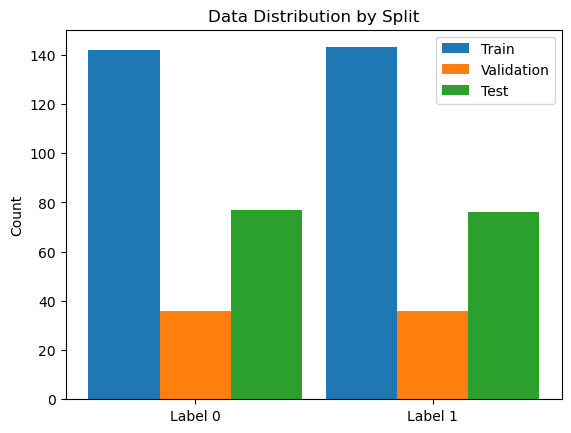

In [18]:
# Create the bar graph
train_counts = [output_train.count(0), output_train.count(1)]
val_counts = [output_val.count(0), output_val.count(1)]
test_counts = [output_test.count(0), output_test.count(1)]
labels = ['Label 0', 'Label 1']
x = range(len(labels))
width = 0.3

fig, ax = plt.subplots()
ax.bar(x, train_counts, width, label='Train')
ax.bar([i + width for i in x], val_counts, width, label='Validation')
ax.bar([i + 2*width for i in x], test_counts, width, label='Test')

ax.set_ylabel('Count')
ax.set_title('Data Distribution by Split')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [19]:
def image_process(dataset_path, im_size, images_names):
    count = 0
    images = []
    for f in tqdm(images_names):    
        path =  Path(dataset_path + f )
        img = cv2.imread(dataset_path + f)
        img = cv2.resize(img, (im_size, im_size)) #read through the function.
        x = np.expand_dims(img, axis=0)
               # x = preprocess_input(x)
        images.append(x)

    images = np.array(images).reshape(len(images), im_size, im_size,3)
    return images

In [57]:
input_train = image_process( os.path.join(working_dir, 'images_pred' , 'Train/'), im_size, images_names_train)
input_val = image_process(  os.path.join(working_dir , 'images_pred' , 'Val/'), im_size, images_names_val)
input_test = image_process(  os.path.join(working_dir , 'images_pred' , 'Test/'), im_size, images_names_test)

100%|██████████| 4711/4711 [00:43<00:00, 108.92it/s]


In [58]:
len(input_train), len(labels_train), # len(images_names_test), len(labels_test)

(8780, 8780)

## Creating and Training the model if required

In [59]:
#uncomment this to use the model which has one output neuron at the end.

# def build_model(base_model,im_size):
    
#     # Load the pre-trained EfficientNetB1 model with ImageNet weights
#     base_model = EfficientNetB1(include_top=False, weights='imagenet')

#     # Freeze the base model layers
#     for layer in base_model.layers:
#         layer.trainable = False

#     # Add a GlobalAveragePooling2D layer and a Dense layer on top of the base model
#     x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pool")(base_model.output)
#     x = layers.Dropout(0.25)(x) 
#     outputs = layers.Dense(1, activation = "sigmoid", name = "output_layer")(x)
#     x = layers.Dropout(0.8)(x) 
#     model = tf.keras.Model(inputs=base_model.input, outputs = outputs)

#     # Define the model
# #     model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    
#     model.compile(loss = "BinaryCrossentropy",  #"categorical_crossentropy",
#              optimizer = tf.keras.optimizers.Adam(),
#              metrics = ['accuracy'])

#     return model

In [61]:
def create_model(base_model):

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a GlobalAveragePooling2D layer and a Dense layer on top of the base model
    x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pool")(base_model.output)
    x = layers.Dropout(0.25)(x) 
    outputs = layers.Dense(2, activation = "softmax", name = "output_layer")(x)
    x = layers.Dropout(0.8)(x) 
    model = tf.keras.Model(inputs=base_model.input, outputs = outputs)

    # Define the model
#     model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    
    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() ,  #"categorical_crossentropy",
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

    return model

In [62]:
model_selected = 'EfficientB7'
model3 = create_model(base_model)

In [63]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                          

                                                                                                  
 block1b_add (Add)              (None, None, None,   0           ['block1b_drop[0][0]',           
                                32)                               'block1a_project_bn[0][0]']     
                                                                                                  
 block1c_dwconv (DepthwiseConv2  (None, None, None,   288        ['block1b_add[0][0]']            
 D)                             32)                                                               
                                                                                                  
 block1c_bn (BatchNormalization  (None, None, None,   128        ['block1c_dwconv[0][0]']         
 )                              32)                                                               
                                                                                                  
 block1c_a

 D)                             192)                                                              
                                                                                                  
 block2a_bn (BatchNormalization  (None, None, None,   768        ['block2a_dwconv[0][0]']         
 )                              192)                                                              
                                                                                                  
 block2a_activation (Activation  (None, None, None,   0          ['block2a_bn[0][0]']             
 )                              192)                                                              
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 192)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block2c_activation (Activation  (None, None, None,   0          ['block2c_bn[0][0]']             
 )                              288)                                                              
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 288)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_s

                                                                                                  
 block2e_activation (Activation  (None, None, None,   0          ['block2e_bn[0][0]']             
 )                              288)                                                              
                                                                                                  
 block2e_se_squeeze (GlobalAver  (None, 288)         0           ['block2e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2e_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2e_se_squeeze[0][0]']     
                                                                                                  
 block2e_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block2e_se_reshape[0][0]']     
          

 )                              288)                                                              
                                                                                                  
 block2g_activation (Activation  (None, None, None,   0          ['block2g_bn[0][0]']             
 )                              288)                                                              
                                                                                                  
 block2g_se_squeeze (GlobalAver  (None, 288)         0           ['block2g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2g_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2g_se_squeeze[0][0]']     
                                                                                                  
 block2g_s

 block3b_activation (Activation  (None, None, None,   0          ['block3b_bn[0][0]']             
 )                              480)                                                              
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 480)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_s

                                                                                                  
 block3d_activation (Activation  (None, None, None,   0          ['block3d_bn[0][0]']             
 )                              480)                                                              
                                                                                                  
 block3d_se_squeeze (GlobalAver  (None, 480)         0           ['block3d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3d_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3d_se_squeeze[0][0]']     
                                                                                                  
 block3d_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3d_se_reshape[0][0]']     
          

 )                              480)                                                              
                                                                                                  
 block3f_activation (Activation  (None, None, None,   0          ['block3f_bn[0][0]']             
 )                              480)                                                              
                                                                                                  
 block3f_se_squeeze (GlobalAver  (None, 480)         0           ['block3f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3f_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3f_se_squeeze[0][0]']     
                                                                                                  
 block3f_s

 block4a_dwconv (DepthwiseConv2  (None, None, None,   4320       ['block4a_dwconv_pad[0][0]']     
 D)                             480)                                                              
                                                                                                  
 block4a_bn (BatchNormalization  (None, None, None,   1920       ['block4a_dwconv[0][0]']         
 )                              480)                                                              
                                                                                                  
 block4a_activation (Activation  (None, None, None,   0          ['block4a_bn[0][0]']             
 )                              480)                                                              
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 480)         0           ['block4a_activation[0][0]']     
 agePoolin

                                                                                                  
 block4c_activation (Activation  (None, None, None,   0          ['block4c_bn[0][0]']             
 )                              960)                                                              
                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 960)         0           ['block4c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4c_se_reshape[0][0]']     
          

 )                              960)                                                              
                                                                                                  
 block4e_activation (Activation  (None, None, None,   0          ['block4e_bn[0][0]']             
 )                              960)                                                              
                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 960)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_s

 block4g_bn (BatchNormalization  (None, None, None,   3840       ['block4g_dwconv[0][0]']         
 )                              960)                                                              
                                                                                                  
 block4g_activation (Activation  (None, None, None,   0          ['block4g_bn[0][0]']             
 )                              960)                                                              
                                                                                                  
 block4g_se_squeeze (GlobalAver  (None, 960)         0           ['block4g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4g_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4g_se_squeeze[0][0]']     
          

                                                                                                  
 block4i_bn (BatchNormalization  (None, None, None,   3840       ['block4i_dwconv[0][0]']         
 )                              960)                                                              
                                                                                                  
 block4i_activation (Activation  (None, None, None,   0          ['block4i_bn[0][0]']             
 )                              960)                                                              
                                                                                                  
 block4i_se_squeeze (GlobalAver  (None, 960)         0           ['block4i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4i_s

 D)                             960)                             ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, None, None,   3840       ['block5a_dwconv[0][0]']         
 )                              960)                                                              
                                                                                                  
 block5a_activation (Activation  (None, None, None,   0          ['block5a_bn[0][0]']             
 )                              960)                                                              
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 960)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5c_activation (Activation  (None, None, None,   0          ['block5c_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 1344)        0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_s

                                                                                                  
 block5e_activation (Activation  (None, None, None,   0          ['block5e_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 1344)        0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5e_se_reshape[0][0]']     
          

 )                              1344)                                                             
                                                                                                  
 block5g_activation (Activation  (None, None, None,   0          ['block5g_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5g_se_squeeze (GlobalAver  (None, 1344)        0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_s

 block5i_bn (BatchNormalization  (None, None, None,   5376       ['block5i_dwconv[0][0]']         
 )                              1344)                                                             
                                                                                                  
 block5i_activation (Activation  (None, None, None,   0          ['block5i_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block5i_se_squeeze (GlobalAver  (None, 1344)        0           ['block5i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5i_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5i_se_squeeze[0][0]']     
          

                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, None, None,   33600      ['block6a_dwconv_pad[0][0]']     
 D)                             1344)                                                             
                                                                                                  
 block6a_bn (BatchNormalization  (None, None, None,   5376       ['block6a_dwconv[0][0]']         
 )                              1344)                                                             
                                                                                                  
 block6a_activation (Activation  (None, None, None,   0          ['block6a_bn[0][0]']             
 )                              1344)                                                             
                                                                                                  
 block6a_s

 )                              2304)                                                             
                                                                                                  
 block6c_activation (Activation  (None, None, None,   0          ['block6c_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 2304)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_s

 block6e_bn (BatchNormalization  (None, None, None,   9216       ['block6e_dwconv[0][0]']         
 )                              2304)                                                             
                                                                                                  
 block6e_activation (Activation  (None, None, None,   0          ['block6e_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6e_se_squeeze (GlobalAver  (None, 2304)        0           ['block6e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6e_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6e_se_squeeze[0][0]']     
          

                                                                                                  
 block6g_bn (BatchNormalization  (None, None, None,   9216       ['block6g_dwconv[0][0]']         
 )                              2304)                                                             
                                                                                                  
 block6g_activation (Activation  (None, None, None,   0          ['block6g_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6g_se_squeeze (GlobalAver  (None, 2304)        0           ['block6g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6g_s

 D)                             2304)                            ']                               
                                                                                                  
 block6i_bn (BatchNormalization  (None, None, None,   9216       ['block6i_dwconv[0][0]']         
 )                              2304)                                                             
                                                                                                  
 block6i_activation (Activation  (None, None, None,   0          ['block6i_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6i_se_squeeze (GlobalAver  (None, 2304)        0           ['block6i_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block6k_dwconv (DepthwiseConv2  (None, None, None,   57600      ['block6k_expand_activation[0][0]
 D)                             2304)                            ']                               
                                                                                                  
 block6k_bn (BatchNormalization  (None, None, None,   9216       ['block6k_dwconv[0][0]']         
 )                              2304)                                                             
                                                                                                  
 block6k_activation (Activation  (None, None, None,   0          ['block6k_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 2304)        0           ['block6k_activation[0][0]']     
 agePoolin

                                                                                                  
 block6m_dwconv (DepthwiseConv2  (None, None, None,   57600      ['block6m_expand_activation[0][0]
 D)                             2304)                            ']                               
                                                                                                  
 block6m_bn (BatchNormalization  (None, None, None,   9216       ['block6m_dwconv[0][0]']         
 )                              2304)                                                             
                                                                                                  
 block6m_activation (Activation  (None, None, None,   0          ['block6m_bn[0][0]']             
 )                              2304)                                                             
                                                                                                  
 block6m_s

 )                              3840)                                                             
                                                                                                  
 block7b_activation (Activation  (None, None, None,   0          ['block7b_bn[0][0]']             
 )                              3840)                                                             
                                                                                                  
 block7b_se_squeeze (GlobalAver  (None, 3840)        0           ['block7b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7b_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7b_se_squeeze[0][0]']     
                                                                                                  
 block7b_s

 block7d_bn (BatchNormalization  (None, None, None,   15360      ['block7d_dwconv[0][0]']         
 )                              3840)                                                             
                                                                                                  
 block7d_activation (Activation  (None, None, None,   0          ['block7d_bn[0][0]']             
 )                              3840)                                                             
                                                                                                  
 block7d_se_squeeze (GlobalAver  (None, 3840)        0           ['block7d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7d_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7d_se_squeeze[0][0]']     
          

In [64]:
training_required = True
if training_required: 
    model_path = working_dir + '/' + model_selected +"split_video"+ "new-2outlayers-1frame" + '.hdf5'
    checkpoint = ModelCheckpoint(model_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "max")
    callbacks_list = [checkpoint]
#     model1 = build_model1(base_model)
    history1 = model3.fit(np.array(input_train),
                      np.array(labels_train),
                     epochs = 50,
                     batch_size = 32,
                     validation_data = (np.array(input_val), np.array(labels_val)),
#                      validation_steps = len(input_val)/32,
                     callbacks = callbacks_list 
                    )

Epoch 1/50
275/275 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.7672
Epoch 1: val_accuracy improved from -inf to 0.80625, saving model to C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\EfficientB7split_videonew-2outlayers-1frame.hdf5
275/275 [==============================] - 405s 1s/step - loss: 0.5030 - accuracy: 0.7672 - val_loss: 0.4471 - val_accuracy: 0.8062
Epoch 2/50
275/275 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8151
Epoch 2: val_accuracy improved from 0.80625 to 0.83839, saving model to C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\EfficientB7split_videonew-2outlayers-1frame.hdf5
275/275 [==============================] - 372s 1s/step - loss: 0.4213 - accuracy: 0.8151 - val_loss: 0.4015 - val_accuracy: 0.8384
Epoch 3/50
275/275 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8304
Epoch 3: val_accuracy did not improve from 0.83839
275/275 [==============================] - 365s 1s/step - loss: 0.38

Epoch 29/50
275/275 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.8733
Epoch 29: val_accuracy did not improve from 0.84866
275/275 [==============================] - 385s 1s/step - loss: 0.3005 - accuracy: 0.8733 - val_loss: 0.3673 - val_accuracy: 0.8393
Epoch 30/50
275/275 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8714
Epoch 30: val_accuracy did not improve from 0.84866
275/275 [==============================] - 347s 1s/step - loss: 0.3044 - accuracy: 0.8714 - val_loss: 0.3668 - val_accuracy: 0.8344
Epoch 31/50
275/275 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.8681
Epoch 31: val_accuracy did not improve from 0.84866
275/275 [==============================] - 351s 1s/step - loss: 0.3091 - accuracy: 0.8681 - val_loss: 0.3708 - val_accuracy: 0.8379
Epoch 32/50
275/275 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.8744
Epoch 32: val_accuracy did not improve from 0.84866
275/275 

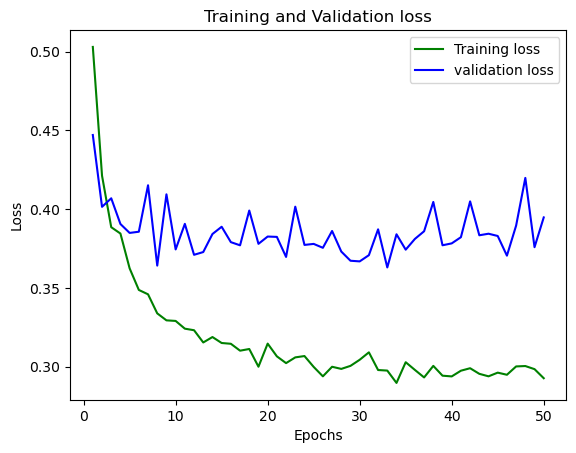

In [65]:
if training_required:
    loss_train = history1.history['loss']
    loss_val = history1.history['val_loss']
    epochs = range(1,51)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(working_dir + '/Training and Validation Loss-B7-new.png')
    plt.show()

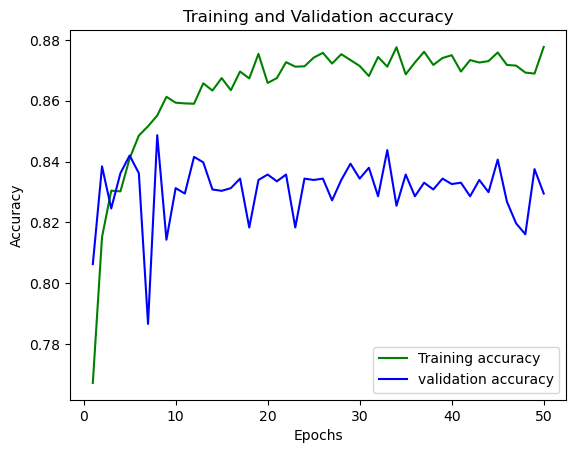

In [66]:
if training_required:
    loss_train = history1.history['accuracy']
    loss_val = history1.history['val_accuracy']
    epochs = range(1,51)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(working_dir + 'Training and Validation Accuracy-B7-new.png')
    plt.show()

In [ ]:
# Prepare predicted outputs based on the threshold
def classify_with_threshold(output_labels, threshold):
    binary_labels = np.zeros_like(output_labels)
    binary_labels[output_labels > threshold] = 1
    return binary_labels

In [ ]:
# Plotting Accuracy VS Threshold plots
def plot_accuracy_with_threshold(threshold_values, accuracy_values, models, data):
    color = ['blue', 'green', 'red']
    for i in range(len(models)):
        plt.plot(threshold_values, accuracy_values[i], linestyle='--', marker='o', color=color[i%3], linewidth=2, markersize=8, label = models[i] )
    plt.grid(True)

    # Add labels and title with fontsize
    plt.xlabel('Threshold Value', fontsize=12)
    plt.ylabel('Accuracy Value', fontsize=12)
    plt.title("Accuracy VS Threshold" + " " + data, fontsize=14)

    # Add a legend
    plt.legend(loc='upper right')
    # Set the axis limits
    plt.xlim([0.4, 1])
    plt.ylim([0.6, 1])
    plt.savefig((working_dir + "/Accuracy VS Threshold" + " " + data + ".png"))
    plt.show()

## Viewing Sample Images

In [ ]:
plt.figure(figsize = (15,12))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    filename = random.choice(images_names_train)
    ind = images_names_train.index(filename)
    if os.path.isfile(os.path.join(working_dir + "/images_pred/Train/" , filename)):
        filepath = os.path.join(working_dir + "/images_pred/Train/" , filename)
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.title(filename + '-Sample' + str(labels_train[ind]))
    plt.axis(False)

In [ ]:
print("Image shape before preprocesing:", img.shape)
print("Image shape after preprocesing:", input_train[0].shape)

# Print the data type of the image
print("Data type:", img.dtype)

# Print the number of channels in the image
print("Number of channels:", img.shape[2])

In [ ]:
#loading the saved model
from tensorflow.keras.models import load_model
model_path = working_dir + '/' + model_selected +"split_video"+ "new-2outlayers-1frame" + '.hdf5'
load_model = load_model(model_path)

In [ ]:
model = load_model
# Remove last layer's softmax
model.layers[-1].activation = None
last_conv_layer_name = 'top_conv'

In [ ]:
load_model.summary()

In [ ]:
# Initialize empty lists for filenames with label 0 and label 1
label_0_files = []
label_1_files = []
label_0 = []
label_1 = []

# Iterate over the input lists and add filenames to the appropriate list based on the label
for filename, label in zip(filenames_train, output_train):
    if label == 0:
        label_0_files.append(filename)
        label_0.append(label)
    else:
        label_1_files.append(filename)
        label_1.append(label)
filenames_train = label_0_files[:255] + label_1_files[:255]
output_train = label_0[:255] + label_1[:255]

In [ ]:
interval = 1
labels_train, images_names_train = extract_helper("Train/", filenames_train, input_dir, output_dir, output_train, interval)

In [ ]:
input_train = image_process(os.path.join(working_dir , 'images_pred' , 'Train/'), im_size, images_names_train)

In [ ]:
frame_count = {}
corrupted_list = []
for video in filenames_train:
    frame_list = []
    for frame in images_names_train:
#         print(video[:-4], frame)
        if frame.startswith(video[:-4] + '-'):
            frame_list.append(frame)
    if len(frame_list) > 0 :
        frame_count[video[:-4]] = frame_list    
    else:
        corrupted_list.append(video)

In [ ]:
from tensorflow.keras.models import load_model
model_path = working_dir + '/' + model_selected +"split_video"+ "new-2outlayers-1frame" + '.hdf5'
load_model = load_model(model_path)
pred_list = []
y_pred_train = []
model = load_model
y_preds = model.predict(input_train)
for i in y_preds:
    if i[0] > i[1]:
        y_pred_train.append(0)
    else:
        y_pred_train.append(1)
        
# y_pred_test = classify_with_threshold(y_preds, 0.5)
pred_list.append(y_pred_train)
pred_list = np.array(pred_list).flatten().astype('int32')
print(accuracy_score(labels_train, pred_list))

In [ ]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #if K.image_dim_ordering() == 'th':
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))


In [ ]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
#     superimposed_img.save(cam_path)

#     Display Grad CAM
    plt.imshow(superimposed_img)

In [ ]:
def return_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
#     superimposed_img.save(cam_path)

#     Display Grad CAM
    return superimposed_img

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
#     plt.imshow(img_array.reshape((240,240,3)))
#     plt.show()
#     print(grad_model.summary())
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

#             sigmoid = tf.keras.activations.sigmoid  # uncomment this when using a single neuron output 
#             sigmoid_x = sigmoid(preds[0])
# #             print(sigmoid_x)
#             if sigmoid_x < 0.5:
#                 result = tf.subtract(1, sigmoid_x)
#                 sigmoid_inv_result = tf.math.log(result / (1 - result))
#                 class_channel = sigmoid_inv_result
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # print(grads.shape)
    # # This is a vector where each entry is the mean intensity of the gradient
    # # over a specific feature map channel
#     print(type(grads), type(last_conv_layer_output), type(class_channel), class_channel  )
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # print(pooled_grads.shape)
    # # We multiply each channel in the feature map array
    # # by "how important this channel is" with regard to the top predicted class
    # # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
#     print(last_conv_layer_output[0], "last_conv_layer_output[0]", last_conv_layer_output.shape, last_conv_layer_output[0].shape, pooled_grads[..., tf.newaxis])
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     plt.matshow(heatmap)
#     plt.show()
    return heatmap.numpy()

In [ ]:
def guided_model(load_model, last_conv_layer_name):
    model = load_model

    model.get_layer(last_conv_layer_name)

    gb_model = tf.keras.models.Model(
        inputs = [model.inputs],    
        outputs = [model.get_layer(last_conv_layer_name).output]
    )
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    
    @tf.custom_gradient
    def guidedRelu(a):
        def grad(dy):
            return tf.cast(dy>0,"float32") * tf.cast(a>0, "float32") * dy
        return tf.nn.relu(a), grad
    for l in layer_dict:
        if l.activation == tf.keras.activations.relu:
            l.activation = guidedRelu
    return gb_model

In [ ]:
def guided_back(preprocessed_input, gb_model):
    with tf.GradientTape() as tp:
        inputs = tf.cast(preprocessed_input, tf.float32)
        tp.watch(inputs)
        outputs = gb_model(inputs)[0]
        grads = tp.gradient(outputs,inputs)[0]
    
    #Visualizing the guided back prop
    gb_prop = grads
#     print(type(gb_prop.numpy()))
    guided_back_viz = np.dstack((
                gb_prop[:, :, 0],
                gb_prop[:, :, 1],
                gb_prop[:, :, 2],
            ))  
#     compare = gb_prop.numpy() == guided_back_viz
#     print(compare.all())
#     print(guided_back_viz)
    guided_back_viz -= np.min(guided_back_viz)
    guided_back_viz /= guided_back_viz.max()
#     print(guided_back_viz)
    return guided_back_viz
#     imgplot = plt.imshow(guided_back_viz)
#     plt.axis("off")
#     plt.show()

In [ ]:
def guided_model_swish(load_model, last_conv_layer_name):
    model = load_model

    model.get_layer(last_conv_layer_name)

    gb_model = tf.keras.models.Model(
        inputs = [model.inputs],    
        outputs = [model.get_layer(last_conv_layer_name).output]
    )
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    # print(layer_dict)
    @tf.custom_gradient
    def guidedSwish(a):
        def grad(dy):
            sigmoid = tf.math.sigmoid(a)
            positive_mask_1 = tf.cast(a>0,"float32") 
            positive_mask_2 = tf.cast(dy>0,"float32") 
            return dy * (sigmoid * (1 + a * (1 - sigmoid))) * positive_mask_1 * positive_mask_2
        return swish(a), grad

    for l in layer_dict:
        if l.activation == tf.keras.activations.swish:
            l.activation = guidedSwish
    return gb_model

In [ ]:
generate_gradcams = False
from tensorflow.keras.models import load_model
model_path = working_dir + '/' + model_selected + "split_video" + "new" + '.hdf5'
load_model = load_model(model_path)
if generate_gradcams:
    last_conv_layer_name = 'top_conv'
    model = load_model
    model.layers[-1].activation = None
    for i, filename in enumerate(tqdm(images_names_test)):

        img_path = os.path.join(working_dir , "images_pred", "Test",filename)
    #     r"C:\Users\AVLguest\work\EfficientNet-VideoAccuracy\images_pred\Test/072122DAIJA1-7R3-frame45.jpg"
        image = cv2.imread(img_path)
        im_size = 240
        img = cv2.resize(image, (im_size, im_size)) #read through the function.
        # x = preprocess_input(img)
        x = np.expand_dims(img, axis = 0)
        # print(x[:,:,:,0:3])
        x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
        heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
    #     plt.matshow(heatmap)
        if  pred_list[i] == labels_test[i]:
            string = "Y-" + str(labels_test[i]) + "-"
        else:
            string = "N-" + str(labels_test[i]) + "-"
        filename = string + filename
        output_path = os.path.join(working_dir, "TestGradCams-Allframes-1", filename)
        save_and_display_gradcam(img_path, heatmap, output_path, alpha=0.4)


In [ ]:
generate_guided_backprops = False
from tensorflow.keras.models import load_model
model_path = working_dir + '/' + model_selected + "split_video" + "new" + '.hdf5'
load_model = load_model(model_path)
if generate_guided_backprops:
    last_conv_layer_name = 'top_conv'
    model = load_model
    model.layers[-1].activation = None
    for i, filename in enumerate(tqdm(images_names_test)):

        img_path = os.path.join(working_dir , "images_pred", "Test",filename)
        image = cv2.imread(img_path)
        im_size = 240
        img = cv2.resize(image, (im_size, im_size)) #read through the function.
        x = np.expand_dims(img, axis = 0)
        x = np.array(x[:,:,:,0:3]).reshape(1,im_size, im_size, 3)
        gb_model = guided_model(load_model, last_conv_layer_name)
        output = deprocess_image(guided_back(x, gb_model))
#         jet_heatmap = keras.utils.array_to_img(output)
#         jet_heatmap = jet_heatmap.resize((image.shape[0], image.shape[0]))
#         jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        if  pred_list[i] == labels_test[i]:
            string = "Y-" + str(labels_test[i]) + "-"
        else:
            string = "N-" + str(labels_test[i]) + "-"
        filename = string + filename
#         print(image.shape)
        superimposed_img = keras.utils.array_to_img(output)
        superimposed_img = superimposed_img.resize((image.shape[1], image.shape[0]))
#         print(keras.utils.img_to_array(superimposed_img).shape)
        backprop_path = os.path.join(r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\Testbackprop-Allframes-1-top-conv", filename)
        superimposed_img.save(backprop_path)

In [ ]:
generate_guided_gradcams = False
from tensorflow.keras.models import load_model
model_path = working_dir + '/' + model_selected + "split_video" + "new" + '.hdf5'
load_model = load_model(model_path)
if generate_guided_gradcams:
    last_conv_layer_name = 'top_conv'
    model = load_model
    model.layers[-1].activation = None
    im_size = 240
    for i, filename in enumerate(tqdm(images_names_test)):

        img_path = os.path.join(working_dir , "images_pred", "Test",filename)
        image = cv2.imread(img_path)
        img = cv2.resize(image, (im_size, im_size)) #read through the function.
        x = np.expand_dims(img, axis = 0)

        heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
        cam = cv2.resize(heatmap, (im_size,im_size))
        gb_model = guided_model(model, last_conv_layer_name)
        output = guided_back(x, gb_model)

        gd_gb = np.dstack((
                output[:, :, 0] * cam,
                output[:, :, 1] * cam,
                output[:, :, 2] * cam,
            )) 
        gd_gb = deprocess_image(gd_gb)
        if  pred_list[i] == labels_test[i]:
            string = "Y-" + str(labels_test[i]) + "-"
        else:
            string = "N-" + str(labels_test[i]) + "-"
        filename = string + filename

        guided_img = keras.utils.array_to_img(gd_gb)
        guided_img = guided_img.resize((image.shape[1], image.shape[0]))
        backprop_path = os.path.join(r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\TestGuidedgradcam-Allframes-1-top-conv", filename)
        guided_img.save(backprop_path)

# print(res_heat.shape, output.shape, gd_gb.shape)

In [ ]:
# from tensorflow.keras.models import load_model
videos = [string + '.avi' for string in frame_count.keys()]
# direc = r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\images_pred"
# input_test_1 = image_process(os.path.join(direc, "Test/"), 240, images_names_test)
# path1 = r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\EfficientB1split_videonew.hdf5"
# model1 = load_model(path1)
# y_pred_test = model1.predict(input_test_1)
# y_pred_test_1 = (classify_with_threshold(y_pred_test, 0.5))
# predictions_test = y_pred_test_1.astype(int).flatten().tolist()
# print(accuracy_score(labels_test1, predictions_test))

## Visualization of prediction of frames in a video using a bar plot

In [ ]:
fig, ax = plt.subplots(figsize = (50,50))

# Set plot parameters
bar_width = 0.5
opacity = 0.8
colors = ['blue', 'red']
legend = ['Prediction 0', 'Prediction 1']

# Iterate over videos
for i in range(len(videos)):
    x_pos = i + 1
    
    bottom = 0
    
    for j in range(len(frame_count[videos[i][:-4]])):
        height = 1
        image_name = frame_count[videos[i][:-4]][j]
        ind = images_names_train.index(image_name)
        color = colors[pred_list[ind]]
        
        ba = ax.bar(x_pos, height, bar_width, bottom=bottom, color=color, alpha=opacity, label = legend[pred_list[ind]] )
        
        bottom += height
    plt.text(i+1, j + 1, str(output_train[i]), ha='center')

legend1 = ax.legend(handles=[ba], 
                   labels=['Prediction 0'],
                   loc='upper right', fontsize='large')

ax.add_artist(legend1)

legend2 = ax.legend(handles=[ba], 
                   labels=['Prediction 1'],
                   loc='upper left', fontsize='large')

ax.add_artist(legend2)

legend1.legendHandles[0].set_color('blue')
legend2.legendHandles[0].set_color('red')

ax.set_xticks(np.arange(len(videos))[::1] + 1)
ax.set_xticklabels(videos, rotation = 90)

ax.set_ylabel('Frames')
ax.set_title('Visualization of each frame prediction(Train Data)-EfficientNet-B1-0.5(Numbers on Top of each bar are actual Labels of the video)')
    
plt.savefig(r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\Train Data Prediction Visualization - 2 layers(EfficientNet-B1-0.5).png")
plt.show()

## Visualization of Grad-CAM and Guided BackProp frame by frame for each video

In [ ]:
#video creation for all three methods combined
from tensorflow.keras.models import load_model

# img_dir = r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\TestCams-Allframes-1"
# video_name = "081222DAIJA1-1R7" 
frames = []
filenames = []
# image_list = os.listdir(img_dir)

model_path = working_dir + '/' + model_selected +"split_video"+ "new-2outlayers-1frame" + '.hdf5'
model = load_model(model_path)

model.layers[-1].activation = None
last_conv_layer_name = 'top_conv' 

# # # Define video dimensions and codec
width, height = (1000,1000)
video_size = (width, height)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

# video_writer = cv2.VideoWriter(r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\GRADCAM_videos/train-croptop-0.2/" + video_name + ".mp4", fourcc, 30, video_size, True)

# Define text overlays
# title = video_name
font = cv2.FONT_HERSHEY_SIMPLEX
# title_position = (int(width/2) - 100, 50)
# label_position = (50, height-50)
# pred_position = (50, height - 20)
# frame_position = (50, height - 80)
label_position = (510, 530)
orig_position = (360, 490)
grad_position = (510, 490)
bp_position = (200, 530)
guid_position = (510, 530)

for video_name in tqdm(frame_count.keys()):
    video_writer = cv2.VideoWriter(r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\GRADCAM_videos/Train-2neurons/" + video_name + ".mp4", fourcc, 30, video_size, True)
    label_number = 0
#     print(frame_count[video_name])
    frame_list = []
    prob_list = []
    for frame in frame_count[video_name]:
#         print(frame)
        img_path = os.path.join(working_dir , "images_pred", "Train", frame)
#         print(img_path)
        image = cv2.imread(img_path)
#         height, width = image.shape[:2]
        # calculate the new dimensions of the cropped image
#         new_width = int(width * 0.2)
#         new_height = int(height * 0.2)
        # crop the image with the new dimensions
#         cropped_image = image[int(new_height):height, :]
        image = cv2.resize(image, (im_size, im_size)) #read through the function.
#         plt.imshow(cropped_image)
#         plt.show()
        x = np.expand_dims(image, axis=0)
        

        heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
        grad_cam = return_gradcam(img_path, heatmap, alpha=0.4)

        gb_model = guided_model_swish(model, last_conv_layer_name)
        output = deprocess_image(guided_back(x, gb_model))
        gb_img = keras.utils.array_to_img(output)
         
#         cam = cv2.resize(heatmap, (im_size, im_size))
#         gd_gb = np.dstack((
#                 output[:, :, 0] * cam,
#                 output[:, :, 1] * cam,
#                 output[:, :, 2] * cam,
#             )) 
#         gd_gb = deprocess_image(gd_gb)
#         guided_img = keras.utils.array_to_img(gd_gb)
        
        # Resize all images to a common size of 500x500
        img1 = cv2.resize(image, (500, 500))
        img2 = cv2.cvtColor(cv2.resize(keras.utils.img_to_array(grad_cam), (500, 500)), cv2.COLOR_BGR2RGB) 
        img3 = cv2.resize(keras.utils.img_to_array(gb_img), (500, 500))
#         img4 = cv2.resize(keras.utils.img_to_array(guided_img), (500, 500))
        
#         plt.imshow(grad_cam)
#         plt.show()
        # Create a blank canvas of size 1000x1000
        collage = np.zeros((1000, 1000, 3), dtype='uint8')
        
        ind = images_names_train.index(frame)
        pred = pred_list[ind]
        label = labels_train[ind]
        
        prob_0 = round(y_preds[ind][0], 3)
        prob_1 = round(y_preds[ind][1], 3)
        
        frame_list.append(label_number)
        if label == 0 :
            prob_list.append(prob_0)
            prob_pointer = prob_0
        else:
            prob_list.append(prob_1)
            prob_pointer = prob_1
#         print(frame_list, prob_list)
        fig, ax = plt.subplots()
        ax.plot(frame_list, prob_list)
        ax.axhline(y=0.5, color='r', linestyle='-')
        ax.set_xlabel('Frame Number')
        ax.set_ylabel('Probability of Label')
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax.set_xlim(0, len(frame_count[video_name]))
        ax.grid(True)
        last_x, last_y = frame_list[-1], prob_pointer
        ax.annotate(prob_pointer, xy=(last_x, last_y), xytext=(30, -30), 
            textcoords='offset points', arrowprops=dict(arrowstyle='->'))
#         ax.set_facecolor('k')

        # convert the plot to an image array
        buffer = BytesIO()
        fig.savefig(buffer, format='png', transparent=False)
        buffer.seek(0)
        image = Image.open(buffer)
        image_array = np.array(image.convert('RGB'))
#         print(image_array.shape, image_array)
        image_array = cv2.resize(image_array, (500, 500))
        inverted_img = 255 - image_array
        plt.close()
        # Add the four images to the canvas
        collage[0:500, 0:500] = img1
        collage[0:500, 500:1000] = img2 
        collage[500:1000, 0:500] = img3 
        collage[500:1000, 500:1000] = inverted_img
#         plt.imshow(image_array)
#         plt.show()
        
#         # Add time delay
        for j in range(30):
            video_writer.write(collage)
            
            # Add label overlay
            label_text =  "Label - " + str(label)
            pred_text = 'Pred-' + str(pred) + "("  + str(prob_0) + "," + str(prob_1) + ")"
            frame_text = "Frame " + str(label_number)
            label_text = label_text + " " + frame_text + " " + pred_text
            
            orig_text = "ORIGINAL"
            grad_text = "GRAD-CAM"
            bp_text = "GUIDED-BACKPROP"
#             guid_text = "GUIDED-GRADCAM"
            
            cv2.putText(collage, label_text, label_position, font, 0.7, (255,255,255), 2, cv2.LINE_AA)
#             cv2.putText(collage, pred_text, pred_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
#             cv2.putText(collage, frame_text, frame_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
            if label_number < 2:
                cv2.putText(collage, orig_text, orig_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
                cv2.putText(collage, grad_text, grad_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
                cv2.putText(collage, bp_text, bp_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
#                 cv2.putText(collage, guid_text, guid_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
            
        label_number += 1
        
    # Release video writer object
    video_writer.release()

## Creating the videos using the 2 output neurons model also.

In [ ]:
# def make_gradcam_heatmap1(img_array, model, last_conv_layer_name, pred_index=None):
#     # First, we create a model that maps the input image to the activations
#     # of the last conv layer as well as the output predictions
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
#     )
# #     plt.imshow(img_array.reshape((240,240,3)))
# #     plt.show()
# #     print(grad_model.summary())
#     # Then, we compute the gradient of the top predicted class for our input image
#     # with respect to the activations of the last conv layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#             class_channel = preds[:, pred_index]
#     # This is the gradient of the output neuron (top predicted or chosen)
#     # with regard to the output feature map of the last conv layer
#     grads = tape.gradient(class_channel, last_conv_layer_output)
#     # print(grads.shape)
#     # # This is a vector where each entry is the mean intensity of the gradient
#     # # over a specific feature map channel
# #     print(type(grads), type(last_conv_layer_output), type(class_channel), class_channel  )
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     # print(pooled_grads.shape)
#     # # We multiply each channel in the feature map array
#     # # by "how important this channel is" with regard to the top predicted class
#     # # then sum all the channels to obtain the heatmap class activation
#     last_conv_layer_output = last_conv_layer_output[0]
# #     print(last_conv_layer_output[0], "last_conv_layer_output[0]", last_conv_layer_output.shape, last_conv_layer_output[0].shape, pooled_grads[..., tf.newaxis])
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

#     # # For visualization purpose, we will also normalize the heatmap between 0 & 1
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
# #     plt.matshow(heatmap)
# #     plt.show()
#     return heatmap.numpy()

In [ ]:
# from tensorflow.keras.models import load_model
# # videos = [string + '.avi' for string in frame_count.keys()]
# # direc = r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\images_pred"
# # input_test_1 = image_process(os.path.join(direc, "Test/"), 240, images_names_test)
# path1 = r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\EfficientB1split_videonew-2outlayers.hdf5"
# model1 = load_model(path1)
# pred_list1 = []
# y_preds1 = model1.predict(input_test)
# print(y_preds1)
# y_pred_test1 = []
# for i in y_preds1:
#     if i[0] > i[1]:
#         y_pred_test1.append(0)
#     else:
#         y_pred_test1.append(1)
# print(y_pred_test1)
# # y_pred_test1 = classify_with_threshold(y_preds1, 0.5)
# pred_list1.append(y_pred_test1)
# pred_list1 = np.array(pred_list1).flatten()
# print(accuracy_score(labels_test, pred_list1))

In [ ]:
# y_preds1

In [ ]:
# #video creation for all three methods combined
# from tensorflow.keras.models import load_model

# # img_dir = r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\TestCams-Allframes-1"
# video_name = "092922DAIJA1-11R4" 
# frames = []
# filenames = []
# # image_list = os.listdir(img_dir)

# model_path = working_dir + '/' + "EfficientB1split_videonew-2outlayers.hdf5"
# model = load_model(model_path)

# model.layers[-1].activation = None
# last_conv_layer_name = 'top_conv' 

# # # # Define video dimensions and codec
# width, height = (1000,1000)
# video_size = (width, height)
# fourcc = cv2.VideoWriter_fourcc(*"mp4v")

# video_writer = cv2.VideoWriter(r"C:\Users\AVLguest\work\EfficientNet-GRAD-CAM\GRADCAM_videos-2/" + video_name + "-All" + ".mp4", fourcc, 30, video_size, True)

# # Define text overlays
# title = video_name
# font = cv2.FONT_HERSHEY_SIMPLEX
# title_position = (int(width/2) - 100, 50)
# label_position = (50, height-50)
# pred_position = (50, height - 20)
# frame_position = (50, height - 80)
# orig_position = (360, 490)
# grad_position = (510, 490)
# bp_position = (200, 530)
# guid_position = (510, 530)

# if video_name in frame_count.keys():
#     label_number = 0
# #     print(frame_count[video_name])
#     for frame in frame_count[video_name]:
#         img_path = os.path.join(working_dir , "images_pred", "Test", frame)
# #         print(img_path)
#         image = cv2.imread(img_path)
#         img = cv2.resize(image, (im_size, im_size)) 
#         x = np.expand_dims(img, axis = 0)

#         heatmap = make_gradcam_heatmap1(x, model, last_conv_layer_name)
#         grad_cam = return_gradcam(img_path, heatmap, alpha=0.4)

#         gb_model = guided_model(model, last_conv_layer_name)
#         output = deprocess_image(guided_back(x, gb_model))
#         gb_img = keras.utils.array_to_img(output)
         
#         cam = cv2.resize(heatmap, (im_size, im_size))
#         gd_gb = np.dstack((
#                 output[:, :, 0] * cam,
#                 output[:, :, 1] * cam,
#                 output[:, :, 2] * cam,
#             )) 
#         gd_gb = deprocess_image(gd_gb)
#         guided_img = keras.utils.array_to_img(gd_gb)
        
#         # Resize all images to a common size of 500x500
#         img1 = cv2.resize(img, (500, 500))
#         img2 = cv2.cvtColor(cv2.resize(keras.utils.img_to_array(grad_cam), (500, 500)), cv2.COLOR_BGR2RGB) 
#         img3 = cv2.resize(keras.utils.img_to_array(gb_img), (500, 500))
#         img4 = cv2.resize(keras.utils.img_to_array(guided_img), (500, 500))
        
# #         plt.imshow(grad_cam)
# #         plt.show()
#         # Create a blank canvas of size 1000x1000
#         collage = np.zeros((1000, 1000, 3), dtype='uint8')

#         # Add the four images to the canvas
#         collage[0:500, 0:500] = img1
#         collage[0:500, 500:1000] = img2 
#         collage[500:1000, 0:500] = img3 
#         collage[500:1000, 500:1000] = img4
        
#         ind = images_names_test.index(frame)
#         pred = pred_list1[ind]
#         label = labels_test[ind]
#         prob_0 = y_preds1[ind][0]
#         prob_1 = y_preds1[ind][1]
# #         print(images_names_test1.index(frame), frame, pred, label)

# #         # Add time delay
#         for j in range(30):
#             video_writer.write(collage)
            
#             # Add label overlay
#             label_text =  "Label - " + str(label)
#             pred_text = 'Predicted - ' + str(pred) + "("  + str(prob_0) + "," + str(prob_1) + ")"
#             frame_text = "Frame " + str(label_number)
            
#             orig_text = "ORIGINAL"
#             grad_text = "GRAD-CAM"
#             bp_text = "GUIDED-BACKPROP"
#             guid_text = "GUIDED-GRADCAM"
            
#             cv2.putText(collage, label_text, label_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
#             cv2.putText(collage, pred_text, pred_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
#             cv2.putText(collage, frame_text, frame_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
#             if label_number < 2:
#                 cv2.putText(collage, orig_text, orig_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
#                 cv2.putText(collage, grad_text, grad_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
#                 cv2.putText(collage, bp_text, bp_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
#                 cv2.putText(collage, guid_text, guid_position, font, 1, (255,255,255), 2, cv2.LINE_AA)
            
#         label_number += 1
        
#     # Release video writer object
#     video_writer.release()

In [ ]:
# # difference in prediction between 1 output neuron and 2 output neurons
# a = pred_list1 == pred_list
# a.tolist().count(True), a.tolist().count(False)

In [ ]:
# generate_gradcams = False
# from tensorflow.keras.models import load_model
# model_path = working_dir + '/' + "EfficientB1split_videonew-2outlayers" + '.hdf5'
# load_model = load_model(model_path)
# if generate_gradcams:
#     last_conv_layer_name = 'top_conv'
#     model = load_model
#     model.layers[-1].activation = None
#     for i, filename in enumerate(tqdm(images_names_test)):

#         img_path = os.path.join(working_dir , "images_pred", "Test",filename)
#     #     r"C:\Users\AVLguest\work\EfficientNet-VideoAccuracy\images_pred\Test/072122DAIJA1-7R3-frame45.jpg"
#         image = cv2.imread(img_path)
#         im_size = 240
#         img = cv2.resize(image, (im_size, im_size)) #read through the function.
#         # x = preprocess_input(img)
#         x = np.expand_dims(img, axis = 0)
#         # print(x[:,:,:,0:3])
#         x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
#         heatmap = make_gradcam_heatmap1(x, model, last_conv_layer_name)
#     #     plt.matshow(heatmap)
#         if  pred_list1[i] == labels_test[i]:
#             string = "Y-" + str(labels_test[i]) + "-"
#         else:
#             string = "N-" + str(labels_test[i]) + "-"
#         filename = string + filename
#         output_path = os.path.join(working_dir, "TestGradCams-Allframes-1-2layers", filename)
#         save_and_display_gradcam(img_path, heatmap, output_path, alpha=0.4)